데이터 전처리 (범주형50 + 이산형50)

In [ ]:
import numpy as np
import pandas as pd
import gc
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform

# ===============================================================
# 0. Korean font setup
# ===============================================================
system_name = platform.system()
if system_name == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False
print("Font setup complete!")


# ===============================================================
# 1. parquet auto-discovery + load into globals()
# ===============================================================
base_dir = Path("data")

folder_map = {
    "customer":    "1.회원정보",
    "credit":      "2.신용정보",
    "sales":       "3.승인매출정보",
    "billing":     "4.청구입금정보",
    "balance":     "5.잔액정보",
    "channel":     "6.채널정보",
    "marketing":   "7.마케팅정보",
    "performance": "8.성과정보",
}
info_categories = list(folder_map.keys())


def find_parquet_file(folder: Path):
    """Find train*.parquet inside folder"""
    files = list(folder.glob("train*.parquet"))
    if len(files) == 0:
        raise FileNotFoundError(f"train*.parquet not found in {folder}")
    return files[0]


for prefix in info_categories:
    folder = base_dir / folder_map[prefix]
    file_path = find_parquet_file(folder)
    df = pd.read_parquet(file_path)
    globals()[f"{prefix}_train"] = df
    print(f"Loaded {prefix}_train: {df.shape}")


# ===============================================================
# 2. Concat monthly datasets (supports multi-month)
# ===============================================================
train_dfs = {}
for prefix in info_categories:
    df_list = [globals()[f"{prefix}_train"]]
    train_dfs[f"{prefix}_train_df"] = pd.concat(df_list, axis=0)
    print(f"{prefix}_train_df created: {train_dfs[f'{prefix}_train_df'].shape}")

customer_train_df    = train_dfs["customer_train_df"]
credit_train_df      = train_dfs["credit_train_df"]
sales_train_df       = train_dfs["sales_train_df"]
billing_train_df     = train_dfs["billing_train_df"]
balance_train_df     = train_dfs["balance_train_df"]
channel_train_df     = train_dfs["channel_train_df"]
marketing_train_df   = train_dfs["marketing_train_df"]
performance_train_df = train_dfs["performance_train_df"]

gc.collect()


# ===============================================================
# 3. Merge all dataframes on ID
# ===============================================================
from functools import reduce

COMMON_ID = "ID"
CONFLICT_COL = "기준년월"

data_to_merge = [
    customer_train_df, credit_train_df, sales_train_df,
    billing_train_df, balance_train_df, channel_train_df,
    marketing_train_df, performance_train_df
]

processed_list = []
for df in data_to_merge:
    df2 = df.copy()
    if CONFLICT_COL in df2.columns and CONFLICT_COL != COMMON_ID:
        df2 = df2.drop(columns=[CONFLICT_COL])
    processed_list.append(df2)

merged_train_df = reduce(
    lambda left, right: pd.merge(left, right, on=COMMON_ID, how='left'),
    processed_list
)

print("Merge done:", merged_train_df.shape)


# ===============================================================
# 4. Feature separation (numerical vs categorical)
# ===============================================================
target_col = "Segment"
id_col = ["customer_id"]  # will be ignored if not exists

features_df = merged_train_df.drop(columns=[target_col] + id_col, errors='ignore')

Discrimination_criteria = 30

initial_categorical = features_df.select_dtypes(include=['object', 'category']).columns.tolist()
initial_numerical = features_df.select_dtypes(include=np.number).columns.tolist()

refined_categorical = initial_categorical.copy()
refined_numeric = []

for col in initial_numerical:
    if features_df[col].nunique(dropna=True) < Discrimination_criteria:
        refined_categorical.append(col)
    else:
        refined_numeric.append(col)

print("Numeric:", len(refined_numeric))
print("Categorical:", len(refined_categorical))


# ===============================================================
# 5. Feature ranking: ANOVA (numeric) + Chi2 (categorical)
#    IMPORTANT: do NOT truncate to 50 here
# ===============================================================
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import f_classif, chi2

y = merged_train_df[target_col]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- ANOVA numeric ---
X_num = features_df[refined_numeric].fillna(0)
f_scores, p_values = f_classif(X_num, y_encoded)

num_results_df = pd.DataFrame({
    "Feature": refined_numeric,
    "F_Score": f_scores,
    "P_Value": p_values
}).sort_values(by="F_Score", ascending=False)

# --- Chi2 categorical ---
X_cat = features_df[refined_categorical].astype(str).fillna("Missing")
ord_enc = OrdinalEncoder()
X_cat_encoded = ord_enc.fit_transform(X_cat)
chi_scores, p_vals_cat = chi2(X_cat_encoded, y_encoded)

cat_results_df = pd.DataFrame({
    "Feature": refined_categorical,
    "Chi2_Score": chi_scores,
    "P_Value": p_vals_cat
}).sort_values(by="Chi2_Score", ascending=False)

# Build large rankings so we can slice later
TOP_NUM_MAX = len(num_results_df) # enough for 110
TOP_CAT_MAX = len(cat_results_df)   # enough for 135

top_num_features_all = num_results_df["Feature"].head(TOP_NUM_MAX).tolist()
top_cat_features_all = cat_results_df["Feature"].head(TOP_CAT_MAX).tolist()

print("Ranking sizes => numeric:", len(top_num_features_all), "| categorical:", len(top_cat_features_all))


# ===============================================================
# 6. Utility: preprocessing function (reusable for 100 / 245 / full)
# ===============================================================
from sklearn.preprocessing import OrdinalEncoder

def preprocess_tree_features(X_df, discrimination_criteria=30):
    """Numeric: fillna(0), clip>=0, cap p99, log1p
       Categorical: fillna('Missing'), ordinal encode (unknown=-1)
    """
    X = X_df.copy()

    # Identify by dtype
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

    # Treat low-cardinality numeric as categorical
    refined_cat = list(cat_cols)
    refined_num = []
    for c in num_cols:
        if X[c].nunique(dropna=True) < discrimination_criteria:
            refined_cat.append(c)
        else:
            refined_num.append(c)

    # Numeric processing
    if len(refined_num) > 0:
        X[refined_num] = X[refined_num].apply(pd.to_numeric, errors="coerce")
        X[refined_num] = X[refined_num].fillna(0)
        X[refined_num] = X[refined_num].clip(lower=0)

        for c in refined_num:
            p99 = X[c].quantile(0.99)
            X[c] = X[c].clip(upper=p99)

        for c in refined_num:
            X[c] = np.log1p(X[c])

    # Categorical processing
    encoder = None
    if len(refined_cat) > 0:
        X[refined_cat] = X[refined_cat].astype(str).fillna("Missing")
        encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X[refined_cat] = encoder.fit_transform(X[refined_cat])

    # Ensure numeric output
    X = X.apply(pd.to_numeric, errors="coerce").fillna(0)

    return X, refined_num, refined_cat


# ===============================================================
# 7. Build Top-100, Top-245, Full datasets (FIXED)
# ===============================================================

# --- Top-100 (50 num + 50 cat) ---
features_100 = top_num_features_all[:50] + top_cat_features_all[:50]
X_100_raw = merged_train_df[features_100].copy()

# --- Top-245 (110 num + 135 cat) ---
features_245 = top_num_features_all[:110] + top_cat_features_all[:135]
X_245_raw = merged_train_df[features_245].copy()

# --- Full (all features except target + ids) ---
id_cols_full = ["customer_id", "ID"]
X_full_raw = merged_train_df.drop(columns=[target_col] + id_cols_full, errors="ignore").copy()

print("[Top-100] raw shape:", X_100_raw.shape)
print("[Top-245] raw shape:", X_245_raw.shape)
print("[Full] raw shape:", X_full_raw.shape)

# Preprocess each (same logic)
X, num_100, cat_100 = preprocess_tree_features(X_100_raw, discrimination_criteria=30)
X_245, num_245, cat_245 = preprocess_tree_features(X_245_raw, discrimination_criteria=30)
X_full, num_full, cat_full = preprocess_tree_features(X_full_raw, discrimination_criteria=30)

print("[Top-100] processed shape:", X.shape, "| num:", len(num_100), "| cat:", len(cat_100))
print("[Top-245] processed shape:", X_245.shape, "| num:", len(num_245), "| cat:", len(cat_245))
print("[Full] processed shape:", X_full.shape, "| num:", len(num_full), "| cat:", len(cat_full))

# Labels
y = y_encoded.copy()
y_245 = y_encoded.copy()
y_full = y_encoded.copy()

print("Done. You can now train with X_245 / X_full, etc.")


Font setup complete!
Loaded customer_train: (400000, 78)
Loaded credit_train: (400000, 42)
Loaded sales_train: (400000, 406)
Loaded billing_train: (400000, 46)
Loaded balance_train: (400000, 82)
Loaded channel_train: (400000, 105)
Loaded marketing_train: (400000, 64)
Loaded performance_train: (400000, 49)
customer_train_df created: (400000, 78)
credit_train_df created: (400000, 42)
sales_train_df created: (400000, 406)
billing_train_df created: (400000, 46)
balance_train_df created: (400000, 82)
channel_train_df created: (400000, 105)
marketing_train_df created: (400000, 64)
performance_train_df created: (400000, 49)
Merge done: (400000, 857)
Numeric: 351
Categorical: 505
Ranking sizes => numeric: 351 | categorical: 505
[Top-100] raw shape: (400000, 100)
[Top-245] raw shape: (400000, 245)
[Full] raw shape: (400000, 855)
[Top-100] processed shape: (400000, 100) | num: 50 | cat: 50
[Top-245] processed shape: (400000, 245) | num: 110 | cat: 135
[Full] processed shape: (400000, 855) | num:

PCA를 통한 피처 수 설정

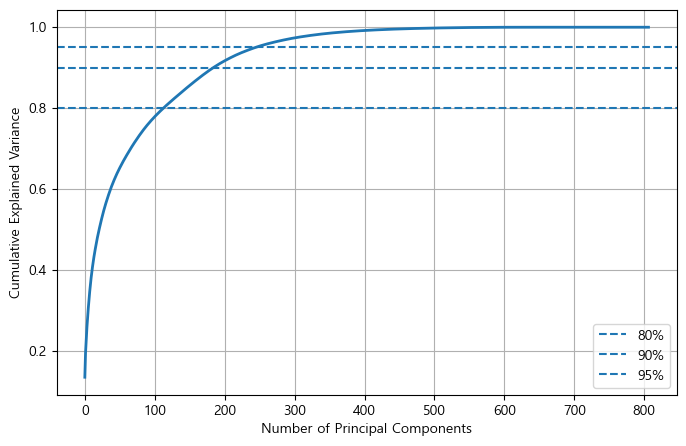

80% variance explained by 114 components
90% variance explained by 185 components
95% variance explained by 245 components


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Numerical features only
X_num_all = merged_train_df.select_dtypes(include=np.number).drop(columns=[target_col], errors="ignore")

pca_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # fill NaN
    ("scaler", StandardScaler()),
    ("pca", PCA())
])

X_pca = pca_pipe.fit_transform(X_num_all)
cum_var = np.cumsum(pca_pipe.named_steps["pca"].explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(cum_var, linewidth=2)
plt.axhline(0.8, linestyle="--", label="80%")
plt.axhline(0.9, linestyle="--", label="90%")
plt.axhline(0.95, linestyle="--", label="95%")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid()
plt.show()

for threshold in [0.8, 0.9, 0.95]:
    n_comp = int(np.argmax(cum_var >= threshold) + 1)
    print(f"{int(threshold*100)}% variance explained by {n_comp} components")

모델 학습(데이터 셋 분리, 교차검증 객체 생성, 성능 평가 함수)

In [18]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, classification_report


from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import numpy as np


# ===============================================================
# 1. Train / Validation / Test Split (60 / 20 / 20)
# ===============================================================
def split_60_20_20(X, y, seed=42):
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.20, random_state=seed, stratify=y
    )
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_full, y_train_full,
        test_size=0.25,  # 0.25 * 0.80 = 0.20
        random_state=seed,
        stratify=y_train_full
    )
    return X_train, X_valid, X_test, y_train, y_valid, y_test


X_train, X_valid, X_test, y_train, y_valid, y_test = split_60_20_20(X, y, seed=42)
X_train_245, X_valid_245, X_test_245, y_train_245, y_valid_245, y_test_245 = split_60_20_20(X, y, seed=42)
X_train_full, X_valid_full, X_test_full, y_train_full, y_valid_full, y_test_full = split_60_20_20(X, y, seed=42)
print("Train:", X_train.shape)
print("Valid:", X_valid.shape)
print("Test :", X_test.shape)


# ===============================================================
# 2. Cross-validation 객체 생성
# ===============================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# ===============================================================
# 3. A_only test_set 생성
# ===============================================================
A_LABEL = int(np.where(le.classes_ == 'A')[0][0])
print("A_LABEL:", A_LABEL)
mask_A = (y_test == A_LABEL)
X_test_A = X_test.loc[mask_A] if hasattr(X_test, "loc") else X_test[mask_A]
y_test_A = y_test[mask_A]
X_test_A_245 = X_test_245.loc[mask_A] if hasattr(X_test_245, "loc") else X_test_245[mask_A]
y_test_A_245 = y_test_245[mask_A]
X_test_A_full = X_test_full.loc[mask_A] if hasattr(X_test_full, "loc") else X_test_full[mask_A]
y_test_A_full = y_test_full[mask_A]

# ===============================================================
# 3. 공통 평가 함수
# ===============================================================
def eval_model(model, X, y, name):
    y_pred = np.asarray(model.predict(X)).reshape(-1)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='macro')
    print(f"[{name}] Accuracy={acc:.4f}, Macro F1={f1:.4f}")
    return acc, f1


def eval_A_only(model, X_A, y_A, A_LABEL, le, name):
    if len(y_A) == 0:
        print(f"\n[{name}] A-only Evaluation skipped (no A samples).")
        return None, None

    y_pred = np.asarray(model.predict(X_A)).reshape(-1)
    recall_A = (y_pred == A_LABEL).mean()

    unique, counts = np.unique(y_pred, return_counts=True)
    dist = dict(zip(unique.tolist(), counts.tolist()))
    dist_named = {le.inverse_transform([k])[0]: v for k, v in dist.items()}

    print(f"\n[{name}] A-only Evaluation")
    print(f"  A Recall (on A-only test) = {recall_A:.4f}")
    print(f"  Predicted label distribution (true=A): {dist_named}")
    return recall_A, dist_named


def eval_A_full(model, X, y, A_LABEL, name):
    y_pred = np.asarray(model.predict(X)).reshape(-1)
    p, r, f1, _ = precision_recall_fscore_support(
        y, y_pred, labels=[A_LABEL], average=None, zero_division=0
    )
    print(f"\n[{name}] A metrics on FULL test")
    print(f"  Precision_A = {p[0]:.4f}")
    print(f"  Recall_A    = {r[0]:.4f}")
    print(f"  F1_A        = {f1[0]:.4f}")
    return p[0], r[0], f1[0]


Train: (240000, 100)
Valid: (80000, 100)
Test : (80000, 100)
A_LABEL: 0


모델 학습(feat: 50, y_가중치 미적용)

In [ ]:
# ===============================================================
# 4-1. XGBoost 모델 및 하이퍼파라미터 튜닝
# ===============================================================
xgb_params = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.03, 0.1],
    "n_estimators": [300, 600, 1000],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0]
}

xgb_model_baseline = XGBClassifier(
    tree_method="hist",
    predictor="auto",
    objective="multi:softmax",
    num_class=len(np.unique(y_encoded)),
    random_state=42
)


xgb_search_baseline = RandomizedSearchCV(
    estimator=xgb_model_baseline,
    param_distributions=xgb_params,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

xgb_search_baseline.fit(X_train, y_train)
best_xgb_baseline = xgb_search_baseline.best_estimator_
print("\nBest XGBoost params:", xgb_search_baseline.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\gs\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:36:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best XGBoost params: {'subsample': 1.0, 'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [ ]:
# ===============================================================
# 4-2. LightGBM 모델 및 하이퍼파라미터 튜닝
# ===============================================================
lgbm_params = {
    "num_leaves": [31, 63, 127],
    "max_depth": [-1, 5, 10],
    "learning_rate": [0.01, 0.03, 0.05],
    "n_estimators": [500, 1000, 1500]
}

lgbm_model_baseline = LGBMClassifier(
    objective="multiclass",
    num_class=5,
    boosting_type="gbdt",
    random_state=42
)


lgbm_search_baseline = RandomizedSearchCV(
    estimator=lgbm_model_baseline,
    param_distributions=lgbm_params,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

lgbm_search_baseline.fit(X_train, y_train)
best_lgbm_baseline = lgbm_search_baseline.best_estimator_
print("\nBest LGBM params:", lgbm_search_baseline.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12555
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 100
[LightGBM] [Info] Start training from score -7.813683
[LightGBM] [Info] Start training from score -9.749337
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -1.927465
[LightGBM] [Info] Start training from score -0.222071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Best LGBM params: {'num_leaves': 127, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.01}


In [ ]:
# ===============================================================
# 4-3. CatBoost 모델 및 하이퍼파라미터 튜닝
# ===============================================================
cat_params = {
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.03, 0.1],
    "iterations": [500, 1000, 1500],
    "l2_leaf_reg": [1, 3, 5, 7]
}

cat_model_baseline = CatBoostClassifier(
    loss_function="MultiClass",
    task_type="GPU",
    devices='0',
    random_seed=42,
    verbose=0,
    thread_count=1,
    gpu_ram_part=0.7
)

cat_search_baseline = RandomizedSearchCV(
    estimator=cat_model_baseline,
    param_distributions=cat_params,
    n_iter=15,
    scoring="f1_macro",
    cv=cv,
    n_jobs=1,
    verbose=1
)

cat_search_baseline.fit(X_train, y_train)
best_cat_baseline = cat_search_baseline.best_estimator_
print("\nBest CatBoost params:", cat_search_baseline.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best CatBoost params: {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 1000, 'depth': 8}


In [ ]:
# ===============================================================
# 5. Validation 및 Test 성능 비교
# ===============================================================
print("\n====== VALIDATION PERFORMANCE ======")
eval_model(best_xgb_baseline, X_valid, y_valid, "XGBoost Valid")
eval_model(best_lgbm_baseline, X_valid, y_valid, "LightGBM Valid")
eval_model(best_cat_baseline, X_valid, y_valid, "CatBoost Valid")

print("\n====== FINAL TEST PERFORMANCE ======") 
eval_model(best_xgb_baseline, X_test, y_test, "XGBoost Test")
eval_model(best_lgbm_baseline, X_test, y_test, "LightGBM Test")
eval_model(best_cat_baseline, X_test, y_test, "CatBoost Test")

print("\n====== A ONLY PERFORMANCE ======")
eval_A_only(best_xgb_baseline, X_test_A, y_test_A, "XGBoost")
eval_A_only(best_lgbm_baseline, X_test_A, y_test_A, "LightGBM")
eval_A_only(best_cat_baseline, X_test_A, y_test_A, "CatBoost")


====== VALIDATION PERFORMANCE ======
[XGBoost Valid] Accuracy=0.8967, Macro F1=0.4615
[LightGBM Valid] Accuracy=0.8930, Macro F1=0.4458
[CatBoost Valid] Accuracy=0.8967, Macro F1=0.4518

====== FINAL TEST PERFORMANCE ======
[XGBoost Test] Accuracy=0.8955, Macro F1=0.4565
[LightGBM Test] Accuracy=0.8922, Macro F1=0.4618
[CatBoost Test] Accuracy=0.8953, Macro F1=0.4570


(0.8952625, 0.45701615957579317)

모델 학습: 기존에 찾은 최적 파라미터를 적용한 학습(빠른 학습을 위해 분리)

In [4]:
# ===============================================================
# 4-4. best_param 기반 학습(재탐색 방지용)
# ===============================================================
BEST_PARAMS_XGB = {
    "max_depth": 4,
    "learning_rate": 0.1,
    "n_estimators": 600,
    "subsample": 1.0,
    "colsample_bytree": 1.0
}

BEST_PARAMS_LGBM = {
    "num_leaves": 127,
    "max_depth": -1,
    "learning_rate": 0.01,
    "n_estimators": 500
}

BEST_PARAMS_CAT = {
    "depth": 8,
    "learning_rate": 0.1,
    "iterations": 1000,
    "l2_leaf_reg": 5
}


# -----------------------------
# 2) Train baseline models (no class weights)
# -----------------------------
num_classes = len(le.classes_)  # safer than len(np.unique(y))

# XGBoost baseline (CPU)
xgb_baseline = XGBClassifier(
    **BEST_PARAMS_XGB,
    tree_method="hist",
    predictor="auto",
    objective="multi:softmax",
    num_class=num_classes,
    random_state=42
)
xgb_baseline.fit(X_train, y_train)

# LightGBM baseline (CPU)
lgbm_baseline = LGBMClassifier(
    **BEST_PARAMS_LGBM,
    objective="multiclass",
    num_class=num_classes,
    boosting_type="gbdt",
    random_state=42
)
lgbm_baseline.fit(X_train, y_train)

# CatBoost baseline (GPU)
cat_baseline = CatBoostClassifier(
    **BEST_PARAMS_CAT,
    loss_function="MultiClass",
    task_type="GPU",
    devices="0",
    random_seed=42,
    verbose=0,
    thread_count=1,
    gpu_ram_part=0.7
)
cat_baseline.fit(X_train, y_train)




c:\Users\gs\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:18:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12555
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 100
[LightGBM] [Info] Start training from score -7.813683
[LightGBM] [Info] Start training from score -9.749337
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -1.927465
[LightGBM] [Info] Start training from score -0.222071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [8]:
# -----------------------------
# 3) Evaluate on Validation / Test
# -----------------------------
print("\n====== BASELINE VALIDATION PERFORMANCE ======")
eval_model(xgb_baseline, X_valid, y_valid, "XGBoost Baseline Valid")
eval_model(lgbm_baseline, X_valid, y_valid, "LightGBM Baseline Valid")
eval_model(cat_baseline, X_valid, y_valid, "CatBoost Baseline Valid")

print("\n====== BASELINE FINAL TEST PERFORMANCE ======")
eval_model(xgb_baseline, X_test, y_test, "XGBoost Baseline Test")
eval_model(lgbm_baseline, X_test, y_test, "LightGBM Baseline Test")
eval_model(cat_baseline, X_test, y_test, "CatBoost Baseline Test")

print("\n====== BASELINE A ONLY PERFORMANCE ======")
eval_A_only(xgb_baseline, X_test_A, y_test_A, A_LABEL, le, "XGBoost Baseline Aonly")
eval_A_only(lgbm_baseline, X_test_A, y_test_A, A_LABEL, le,"LightGBM Baseline Aonly")
eval_A_only(cat_baseline, X_test_A, y_test_A, A_LABEL, le,"CatBoost Baseline Aonly")


====== BASELINE VALIDATION PERFORMANCE ======
[XGBoost Baseline Valid] Accuracy=0.8967, Macro F1=0.4615
[LightGBM Baseline Valid] Accuracy=0.8930, Macro F1=0.4458
[CatBoost Baseline Valid] Accuracy=0.8967, Macro F1=0.4518

====== BASELINE FINAL TEST PERFORMANCE ======
[XGBoost Baseline Test] Accuracy=0.8955, Macro F1=0.4565
[LightGBM Baseline Test] Accuracy=0.8922, Macro F1=0.4618
[CatBoost Baseline Test] Accuracy=0.8953, Macro F1=0.4570

====== BASELINE A ONLY PERFORMANCE ======

[XGBoost Baseline Aonly] A-only Evaluation
  A Recall (on A-only test) = 0.0312
  Predicted label distribution (true=A): {'A': 1, 'C': 31}

[LightGBM Baseline Aonly] A-only Evaluation
  A Recall (on A-only test) = 0.0000
  Predicted label distribution (true=A): {'C': 32}

[CatBoost Baseline Aonly] A-only Evaluation
  A Recall (on A-only test) = 0.0312
  Predicted label distribution (true=A): {'A': 1, 'C': 31}


(np.float64(0.03125), {'A': 1, 'C': 31})

In [ ]:
xgb_baseline.score(X_test ,y_test)
print(classification_report(y_test, xgb_baseline.predict(X_test)))

              precision    recall  f1-score   support

           0       0.33      0.03      0.06        32
           1       0.00      0.00      0.00         5
           2       0.69      0.55      0.62      4253
           3       0.70      0.62      0.66     11642
           4       0.94      0.97      0.95     64068

    accuracy                           0.90     80000
   macro avg       0.53      0.43      0.46     80000
weighted avg       0.89      0.90      0.89     80000



c:\Users\gs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

모델 학습: Segment 분포 불균형으로 인한 y 가중치 부여

In [5]:
from collections import Counter

# y_train은 이미 LabelEncoder로 0~4 인코딩된 상태라고 가정
counter = Counter(y_train)
print("Class counts:", counter)

total_samples = sum(counter.values())
num_classes = len(counter)

# 표준 class weight 공식
raw_class_weights = {
    cls: total_samples / (num_classes * cnt)
    for cls, cnt in counter.items()
}

print("Raw class weights:", raw_class_weights)

Class counts: Counter({np.int64(4): 192206, np.int64(3): 34924, np.int64(2): 12759, np.int64(0): 97, np.int64(1): 14})
Raw class weights: {np.int64(4): 0.2497320583124356, np.int64(3): 1.3744130111098385, np.int64(2): 3.7620503174229953, np.int64(0): 494.8453608247423, np.int64(1): 3428.5714285714284}


In [6]:
## 가중치 과도화 방지 코드
MAX_WEIGHT = 50

class_weights = {
    cls: min(weight, MAX_WEIGHT)
    for cls, weight in raw_class_weights.items()
}

print("Capped class weights:", class_weights)

Capped class weights: {np.int64(4): 0.2497320583124356, np.int64(3): 1.3744130111098385, np.int64(2): 3.7620503174229953, np.int64(0): 50, np.int64(1): 50}


가중치 부여 후 모델 학습(feat 50)

In [19]:
# ===============================================================
# 4-1. XGBoost 모델 및 하이퍼파라미터 튜닝 with Weight
# ===============================================================
xgb_params = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.03, 0.1],
    "n_estimators": [300, 600, 1000],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0]
}

xgb_model = XGBClassifier(
    tree_method="hist",
    predictor="auto",
    objective="multi:softmax",
    num_class=len(np.unique(y_encoded)),
    random_state=42
)


xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_params,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
sample_weights = np.array([class_weights[y] for y in y_train])

xgb_search.fit(X_train, y_train, sample_weight=sample_weights)
best_xgb = xgb_search.best_estimator_
print("\nBest XGBoost params:", xgb_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\gs\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:03:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best XGBoost params: {'subsample': 1.0, 'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


In [20]:
# ===============================================================
# 4-2. LightGBM 모델 및 하이퍼파라미터 튜닝 with Weight
# ===============================================================
lgbm_params = {
    "num_leaves": [31, 63, 127],
    "max_depth": [-1, 5, 10],
    "learning_rate": [0.01, 0.03, 0.05],
    "n_estimators": [500, 1000, 1500]
}

lgbm_model = LGBMClassifier(
    objective="multiclass",
    num_class=5,
    boosting_type="gbdt",
    class_weight=class_weights,
    random_state=42
)


lgbm_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=lgbm_params,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

lgbm_search.fit(X_train, y_train)
best_lgbm = lgbm_search.best_estimator_
print("\nBest LGBM params:", lgbm_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12555
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 100
[LightGBM] [Info] Start training from score -3.428652
[LightGBM] [Info] Start training from score -5.364306
[LightGBM] [Info] Start training from score -1.136430
[LightGBM] [Info] Start training from score -1.136430
[LightGBM] [Info] Start training from score -1.136430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

In [21]:
# ===============================================================
# 4-3. CatBoost 모델 및 하이퍼파라미터 튜닝 with Weight
# ===============================================================

labels = np.unique(y_train)

cat_class_weights = [
    class_weights.get(i, 1.0)   # 혹시 없는 클래스 대비
    for i in range(num_classes)
]

cat_params = {
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.03, 0.1],
    "iterations": [500, 1000, 1500],
    "l2_leaf_reg": [1, 3, 5, 7]
}

cat_model = CatBoostClassifier(
    loss_function="MultiClass",
    task_type="GPU",
    devices='0',
    class_weights=cat_class_weights,
    random_seed=42,
    verbose=0,
    thread_count=1,
    gpu_ram_part=0.7
)

cat_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=cat_params,
    n_iter=15,
    scoring="f1_macro",
    cv=cv,
    n_jobs=1,
    verbose=1
)



cat_search.fit(X_train, y_train)
best_cat = cat_search.best_estimator_
print("\nBest CatBoost params:", cat_search.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best CatBoost params: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 1500, 'depth': 4}


In [30]:
# ===============================================================
# 5. Validation 및 Test 성능 비교 with Weight
# ===============================================================
print("\n====== VALIDATION PERFORMANCE ======")
eval_model(best_xgb, X_valid, y_valid, "XGBoost Valid")
eval_model(best_lgbm, X_valid, y_valid, "LightGBM Valid")
eval_model(best_cat, X_valid, y_valid, "CatBoost Valid")

print("\n====== FINAL TEST PERFORMANCE ======") 
eval_model(best_xgb, X_test, y_test, "XGBoost Test")
eval_model(best_lgbm, X_test, y_test, "LightGBM Test")
eval_model(best_cat, X_test, y_test, "CatBoost Test")

print("\n====== A_only PERFORMANCE ======")
eval_A_only(best_xgb, X_test_A, y_test_A, "XGBoost")
eval_A_only(best_lgbm, X_test_A, y_test_A, "LightGBM")
eval_A_only(best_cat, X_test_A, y_test_A, "CatBoost")


====== VALIDATION PERFORMANCE ======
[XGBoost Valid] Accuracy=0.8325, Macro F1=0.4543
[LightGBM Valid] Accuracy=0.8894, Macro F1=0.4673
[CatBoost Valid] Accuracy=0.8523, Macro F1=0.4642

====== FINAL TEST PERFORMANCE ======
[XGBoost Test] Accuracy=0.8304, Macro F1=0.4408
[LightGBM Test] Accuracy=0.8877, Macro F1=0.4504
[CatBoost Test] Accuracy=0.8516, Macro F1=0.4563

====== A_only PERFORMANCE ======

[XGBoost] A-only Evaluation
  A Recall (on A-only test) = 0.3125
  Predicted label distribution (true=A): {'A': 10, 'C': 22}

[LightGBM] A-only Evaluation
  A Recall (on A-only test) = 0.0000
  Predicted label distribution (true=A): {'C': 32}

[CatBoost] A-only Evaluation
  A Recall (on A-only test) = 0.1250
  Predicted label distribution (true=A): {'A': 4, 'C': 28}


(np.float64(0.125), {'A': 4, 'C': 28})

빠른 학습을 위한 최적 파라미터 적용(feat 50, y 가중치 적용)

In [38]:
# ===============================================================
# 4-4. best_param 기반 학습(재탐색 방지용) with Weight
# ===============================================================
BEST_PARAMS_XGB_Y = {
    "max_depth": 4,
    "learning_rate": 0.01,
    "n_estimators": 600,
    "subsample": 1.0,
    "colsample_bytree": 1.0
}

BEST_PARAMS_LGBM_Y = {
    "num_leaves": 127,
    "max_depth": -1,
    "learning_rate": 0.03,
    "n_estimators": 1500
}

BEST_PARAMS_CAT_Y = {
    "depth": 4,
    "learning_rate": 0.1,
    "iterations": 1500,
    "l2_leaf_reg": 1
}


# -----------------------------
# 2) Train baseline models (no class weights)
# -----------------------------
num_classes = len(le.classes_)  # safer than len(np.unique(y))

# XGBoost baseline (CPU)
xgb_y = XGBClassifier(
    **BEST_PARAMS_XGB_Y,
    tree_method="hist",
    predictor="auto",
    objective="multi:softmax",
    num_class=num_classes,
    random_state=42
)
sample_weights = np.array([class_weights[y] for y in y_train])
xgb_y.fit(X_train, y_train, sample_weight=sample_weights)

# LightGBM baseline (CPU)
lgbm_y = LGBMClassifier(
    **BEST_PARAMS_LGBM_Y,
    objective="multiclass",
    num_class=num_classes,
    boosting_type="gbdt",
    class_weight=class_weights,
    random_state=42
)
lgbm_y.fit(X_train, y_train)

# CatBoost baseline (GPU)
cat_y = CatBoostClassifier(
    **BEST_PARAMS_CAT_Y,
    loss_function="MultiClass",
    task_type="GPU",
    devices="0",
    class_weights=cat_class_weights,
    random_seed=42,
    verbose=0,
    thread_count=1,
    gpu_ram_part=0.7
)
cat_y.fit(X_train, y_train)

c:\Users\gs\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:25:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12555
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 100
[LightGBM] [Info] Start training from score -3.428652
[LightGBM] [Info] Start training from score -5.364306
[LightGBM] [Info] Start training from score -1.136430
[LightGBM] [Info] Start training from score -1.136430
[LightGBM] [Info] Start training from score -1.136430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [39]:
# ===============================================================
# 5. Validation 및 Test 성능 비교 with Weight
# ===============================================================
print("\n====== VALIDATION PERFORMANCE ======")
eval_model(xgb_y, X_valid, y_valid, "XGBoost Valid")
eval_model(lgbm_y, X_valid, y_valid, "LightGBM Valid")
eval_model(cat_y, X_valid, y_valid, "CatBoost Valid")

print("\n====== FINAL TEST PERFORMANCE ======") 
eval_model(xgb_y, X_test, y_test, "XGBoost Test")
eval_model(lgbm_y, X_test, y_test, "LightGBM Test")
eval_model(cat_y, X_test, y_test, "CatBoost Test")

print("\n====== A_only PERFORMANCE ======")
eval_A_only(xgb_y, X_test_A, y_test_A, "XGBoost")
eval_A_only(lgbm_y, X_test_A, y_test_A, "LightGBM")
eval_A_only(cat_y, X_test_A, y_test_A, "CatBoost")


====== VALIDATION PERFORMANCE ======
[XGBoost Valid] Accuracy=0.8325, Macro F1=0.4543
[LightGBM Valid] Accuracy=0.8894, Macro F1=0.4673
[CatBoost Valid] Accuracy=0.8520, Macro F1=0.4638

====== FINAL TEST PERFORMANCE ======
[XGBoost Test] Accuracy=0.8304, Macro F1=0.4408
[LightGBM Test] Accuracy=0.8877, Macro F1=0.4504
[CatBoost Test] Accuracy=0.8514, Macro F1=0.4567

====== A_only PERFORMANCE ======

[XGBoost] A-only Evaluation
  A Recall (on A-only test) = 0.3125
  Predicted label distribution (true=A): {'A': 10, 'C': 22}

[LightGBM] A-only Evaluation
  A Recall (on A-only test) = 0.0000
  Predicted label distribution (true=A): {'C': 32}

[CatBoost] A-only Evaluation
  A Recall (on A-only test) = 0.1250
  Predicted label distribution (true=A): {'A': 4, 'C': 28}


(np.float64(0.125), {'A': 4, 'C': 28})

추가된 학습 함수

In [50]:
def train_tune_evaluate(X, y, le, dataset_name, seed=42):
    print(f"\n==================== DATASET: {dataset_name} ====================")

    # Split
    X_train, X_valid, X_test, y_train, y_valid, y_test = split_60_20_20(X, y, seed=seed)

    print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)
    print("Class distribution (train/valid/test):")
    print("  Train:", Counter(y_train))
    print("  Valid:", Counter(y_valid))
    print("  Test :", Counter(y_test))

    # CV splitter for hyperparam search
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    # A-only test set
    A_LABEL = int(np.where(le.classes_ == 'A')[0][0])
    mask_A = (y_test == A_LABEL)
    X_test_A = X_test.loc[mask_A] if hasattr(X_test, "loc") else X_test[mask_A]
    y_test_A = y_test[mask_A]
    print("A_LABEL:", A_LABEL, "| A in test:", int(mask_A.sum()))

    num_classes = len(le.classes_)

    # -------------------------------
    # XGBoost (CPU)
    # -------------------------------
    xgb_params = {
        "max_depth": [4, 6, 8],
        "learning_rate": [0.01, 0.03, 0.1],
        "n_estimators": [300, 600, 1000],
        "subsample": [0.7, 0.9, 1.0],
        "colsample_bytree": [0.7, 0.9, 1.0]
    }

    xgb_model = XGBClassifier(
        tree_method="hist",
        predictor="auto",
        objective="multi:softmax",
        num_class=num_classes,
        random_state=seed
    )

    xgb_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=xgb_params,
        n_iter=20,
        scoring="f1_macro",
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    xgb_search.fit(X_train, y_train)
    best_xgb = xgb_search.best_estimator_
    print("\nBest XGBoost params:", xgb_search.best_params_)

    # -------------------------------
    # LightGBM (CPU)
    # -------------------------------
    lgbm_params = {
        "num_leaves": [31, 63, 127],
        "max_depth": [-1, 6, 10],
        "learning_rate": [0.01, 0.03, 0.1],
        "n_estimators": [300, 600, 1000],
        "subsample": [0.7, 0.9, 1.0],
        "colsample_bytree": [0.7, 0.9, 1.0]
    }

    lgbm_model = LGBMClassifier(
        objective="multiclass",
        num_class=num_classes,
        random_state=seed
    )

    lgbm_search = RandomizedSearchCV(
        estimator=lgbm_model,
        param_distributions=lgbm_params,
        n_iter=20,
        scoring="f1_macro",
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    lgbm_search.fit(X_train, y_train)
    best_lgbm = lgbm_search.best_estimator_
    print("\nBest LightGBM params:", lgbm_search.best_params_)

    # -------------------------------
    # CatBoost (GPU) - stable settings
    # -------------------------------
    cat_params = {
        "depth": [4, 6, 8],
        "learning_rate": [0.01, 0.03, 0.1],
        "iterations": [500, 1000, 1500],
        "l2_leaf_reg": [1, 3, 5, 7]
    }

    cat_model = CatBoostClassifier(
        loss_function="MultiClass",
        task_type="GPU",
        devices="0",
        random_seed=seed,
        verbose=0,
        thread_count=1,
        gpu_ram_part=0.7
    )

    # IMPORTANT: n_jobs must be 1 for CatBoost GPU stability in sklearn CV
    cat_search = RandomizedSearchCV(
        estimator=cat_model,
        param_distributions=cat_params,
        n_iter=15,
        scoring="f1_macro",
        cv=cv,
        n_jobs=1,
        verbose=1
    )
    cat_search.fit(X_train, y_train)
    best_cat = cat_search.best_estimator_
    print("\nBest CatBoost params:", cat_search.best_params_)

    # -------------------------------
    # Validation performance
    # -------------------------------
    print("\n====== VALIDATION PERFORMANCE ======")
    eval_model(best_xgb, X_valid, y_valid, f"XGBoost {dataset_name} Valid")
    eval_model(best_lgbm, X_valid, y_valid, f"LightGBM {dataset_name} Valid")
    eval_model(best_cat, X_valid, y_valid, f"CatBoost {dataset_name} Valid")

    # -------------------------------
    # Final Test performance
    # -------------------------------
    print("\n====== FINAL TEST PERFORMANCE ======")
    eval_model(best_xgb, X_test, y_test, f"XGBoost {dataset_name} Test")
    eval_model(best_lgbm, X_test, y_test, f"LightGBM {dataset_name} Test")
    eval_model(best_cat, X_test, y_test, f"CatBoost {dataset_name} Test")

    # -------------------------------
    # A-only + A-on-full test
    # -------------------------------
    eval_A_only(best_xgb, X_test_A, y_test_A, A_LABEL, le, f"XGBoost {dataset_name}")
    eval_A_only(best_lgbm, X_test_A, y_test_A, A_LABEL, le, f"LightGBM {dataset_name}")
    eval_A_only(best_cat, X_test_A, y_test_A, A_LABEL, le, f"CatBoost {dataset_name}")

    eval_A_full(best_xgb, X_test, y_test, A_LABEL, f"XGBoost {dataset_name}")
    eval_A_full(best_lgbm, X_test, y_test, A_LABEL, f"LightGBM {dataset_name}")
    eval_A_full(best_cat, X_test, y_test, A_LABEL, f"CatBoost {dataset_name}")

    return {
        "dataset": dataset_name,
        "splits": (X_train, X_valid, X_test, y_train, y_valid, y_test),
        "best_xgb": best_xgb,
        "best_lgbm": best_lgbm,
        "best_cat": best_cat,
        "best_params": {
            "xgb": xgb_search.best_params_,
            "lgbm": lgbm_search.best_params_,
            "cat": cat_search.best_params_,
        }
    }

In [57]:
def train_best_models(X, y, le, best_params, dataset_name, seed=42):
    print(f"\n==================== BEST-PARAM TRAIN: {dataset_name} ====================")

    # 60 / 20 / 20 split
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.20, random_state=seed, stratify=y
    )
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_full, y_train_full,
        test_size=0.25,
        random_state=seed,
        stratify=y_train_full
    )

    num_classes = len(le.classes_)
    A_LABEL = int(np.where(le.classes_ == 'A')[0][0])

    # --------------------
    # XGBoost (CPU)
    # --------------------
    xgb_model = XGBClassifier(
        objective="multi:softmax",
        num_class=num_classes,
        tree_method="hist",
        predictor="auto",
        random_state=seed,
        **best_params["xgb"]
    )
    xgb_model.fit(X_train, y_train)

    # --------------------
    # LightGBM (CPU)
    # --------------------
    lgbm_model = LGBMClassifier(
        objective="multiclass",
        num_class=num_classes,
        random_state=seed,
        **best_params["lgbm"]
    )
    lgbm_model.fit(X_train, y_train)

    # --------------------
    # CatBoost (GPU)
    # --------------------
    cat_model = CatBoostClassifier(
        loss_function="MultiClass",
        task_type="GPU",
        devices="0",
        random_seed=seed,
        verbose=0,
        thread_count=1,
        gpu_ram_part=0.7,
        **best_params["cat"]
    )
    cat_model.fit(X_train, y_train)

    # --------------------
    # Evaluation helpers
    # --------------------
    def eval_basic(model, X, y, name):
        y_pred = np.asarray(model.predict(X)).reshape(-1)
        acc = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average="macro")
        print(f"[{name}] Accuracy={acc:.4f}, Macro F1={f1:.4f}")

    def eval_A(model, X, y, name):
        y_pred = np.asarray(model.predict(X)).reshape(-1)
        recall_A = (y_pred[y == A_LABEL] == A_LABEL).mean() if (y == A_LABEL).sum() > 0 else 0.0
        print(f"[{name}] A Recall (FULL test) = {recall_A:.4f}")

    # --------------------
    # Validation
    # --------------------
    print("\n--- VALIDATION ---")
    eval_basic(xgb_model, X_valid, y_valid, f"XGB {dataset_name}")
    eval_basic(lgbm_model, X_valid, y_valid, f"LGBM {dataset_name}")
    eval_basic(cat_model, X_valid, y_valid, f"CAT {dataset_name}")

    # --------------------
    # Final Test
    # --------------------
    print("\n--- FINAL TEST ---")
    eval_basic(xgb_model, X_test, y_test, f"XGB {dataset_name}")
    eval_basic(lgbm_model, X_test, y_test, f"LGBM {dataset_name}")
    eval_basic(cat_model, X_test, y_test, f"CAT {dataset_name}")

    # --------------------
    # A-class evaluation
    # --------------------
    eval_A_only(best_xgb, X_test_A, y_test_A, A_LABEL, le, f"XGBoost {dataset_name}")
    eval_A_only(best_lgbm, X_test_A, y_test_A, A_LABEL, le, f"LightGBM {dataset_name}")
    eval_A_only(best_cat, X_test_A, y_test_A, A_LABEL, le, f"CatBoost {dataset_name}")

    eval_A(xgb_model, X_test, y_test, f"XGB {dataset_name}")
    eval_A(lgbm_model, X_test, y_test, f"LGBM {dataset_name}")
    eval_A(cat_model, X_test, y_test, f"CAT {dataset_name}")

    return {
        "xgb": xgb_model,
        "lgbm": lgbm_model,
        "cat": cat_model
    }

모델 학습(feat: 245, y 가중치 미적용)

In [52]:
results_245 = train_tune_evaluate(X_245, y_encoded, le, dataset_name="Top-245", seed=42)


==================== DATASET: Top-245 ====================
Train: (240000, 245) Valid: (80000, 245) Test: (80000, 245)
Class distribution (train/valid/test):
  Train: Counter({np.int64(4): 192206, np.int64(3): 34924, np.int64(2): 12759, np.int64(0): 97, np.int64(1): 14})
  Valid: Counter({np.int64(4): 64068, np.int64(3): 11641, np.int64(2): 4253, np.int64(0): 33, np.int64(1): 5})
  Test : Counter({np.int64(4): 64068, np.int64(3): 11642, np.int64(2): 4253, np.int64(0): 32, np.int64(1): 5})
A_LABEL: 0 | A in test: 32
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\gs\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:16:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best XGBoost params: {'subsample': 1.0, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26513
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 244
[LightGBM] [Info] Start training from score -7.813683
[LightGBM] [Info] Start training from score -9.749337
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -1.927465
[LightGBM] [Info] Start training from score -0.222071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [58]:
best_params_245 = {"xgb" : {'subsample': 1.0, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.7},
                   "lgbm":{'subsample': 0.7, 'num_leaves': 127, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.9},
                   "cat":{'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 1500, 'depth': 6}}
models_245_best = train_best_models(
    X_245,
    y_encoded,
    le,
    best_params=best_params_245,
    dataset_name="Top-245"
)


==================== BEST-PARAM TRAIN: Top-245 ====================


c:\Users\gs\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [08:53:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26513
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 244
[LightGBM] [Info] Start training from score -7.813683
[LightGBM] [Info] Start training from score -9.749337
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -1.927465
[LightGBM] [Info] Start training from score -0.222071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

모델 학습(feat: all, y 가중치 미적용)

In [59]:
#메모리 문제로 feat_full 은 feat_245의 최적파라미터를 이용한 결과 값만 볼 것임
models_full_best = train_best_models(
    X_full,
    y_encoded,
    le,
    best_params=best_params_245,
    dataset_name="Full"
)



==================== BEST-PARAM TRAIN: Full ====================


c:\Users\gs\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [08:56:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.250815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76647
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 663
[LightGBM] [Info] Start training from score -7.813683
[LightGBM] [Info] Start training from score -9.749337
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -1.927465
[LightGBM] [Info] Start training from score -0.222071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best